In [1]:
from argparse import ArgumentParser
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import Subset, DataLoader, random_split
import numpy as np
import sys
from xgboost import XGBClassifier
# from utils.utils import get_next_version, train_test_split_persons, train_val_test_split_persons
# from utils.metrics import balanced_composite_report
# from datasets.emotions import emotion_dict, emoint
# sys.path.append(r'C:\Users\luca9\Desktop\Thesis')
import sys
sys.path.append('..')
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt
from utils.SaseFEdatasetFullclas import VideoSaseFEdatasetSingle
from utils.TripletDataset import TripletNetworkDataset
import os
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
input_type= "video"



ModuleNotFoundError: No module named 'utils'

Define the device if GPU is available or not

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

Initialize and apply transformation to the dataset

In [4]:
# np.array(images).shape

In [5]:
np.random.seed(42)
test_size = 0.2
x= np.arange(0, 50, 1, dtype=int)
np.random.shuffle(x)
test_subj = x[:10]

In [6]:
def init_dataset(DATA_FOLDER,n_frames,n_classes=12):
    # add_transforms = [transforms.Resize(224), transforms.Normalize([0.454, 0.390, 0.331], [0.164, 0.187, 0.152])]
    add_transforms = [transforms.Resize(224)]
    print("Loading dataset...")
    train_dataset= TripletNetworkDataset(DATA_FOLDER, n_emt=n_classes, required_frames=n_frames,transforms=add_transforms, test_subj=test_subj,train=True)
    test_dataset = TripletNetworkDataset(DATA_FOLDER, n_emt=n_classes, required_frames=n_frames,transforms=add_transforms, test_subj=test_subj,train=False)
    return train_dataset, test_dataset

train_dataset, test_dataset = init_dataset(DATA_FOLDER, 1)
# images_0,images_1, images_2,_,_= dataset[3]
images,anch_lab, neg_lab= train_dataset[3]
# n_frames = images[0]

Loading dataset...


In [37]:
int2emo={
        0:"Fake-Angry",
        1:"Fake-Contempt",
        2:"Fake-Disgust",
        3:"Fake-Happy",
        4:"Fake-Sad",
        5:"Fake-Surprise",
        6:"Real-Angry",
        7:"Real-Contempt",
        8:"Real-Disgust",
        9:"Real-Happy",
        10:"Real-Sad",
        11:"Real-Surprise"
        
}

In [38]:
# images,anch_lab, neg_lab= train_dataset[3]
# print(int2emo[anch_lab], int2emo[neg_lab])

In [39]:
triplet_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
triplet_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [40]:
print(f"No. of batches in trainloader : {len(triplet_train_loader)}")
print(f"No. of batches in validloader : {len(triplet_test_loader)}")

No. of batches in trainloader : 480
No. of batches in validloader : 118


Load Networs

In [41]:
import timm
import torch.nn.functional as F
class CNN_Model(nn.Module):
    def __init__(self, emb_size=512):
      super().__init__()
      self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
      self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
      self.batchnorm1 = nn.BatchNorm2d(64)
      self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3 ,padding=1)
      self.batchnorm2 = nn.BatchNorm2d(128)
      self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
      self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
      self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
      self.batchnorm3 = nn.BatchNorm2d(256)
      self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
      self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
      self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
      self.batchnorm4 = nn.BatchNorm2d(512)
      self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
      self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
      self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
      self.batchnorm5 = nn.BatchNorm2d(512)

      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
      
      self.fc1 = nn.Linear(25088, 4096)


    def forward(self, images):
      x = F.relu(self.conv1_1(images))
      x = F.relu(self.conv1_2(x))
      x = self.batchnorm1(x)
      x = self.maxpool(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = self.batchnorm2(x)
      x = self.maxpool(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.batchnorm3(x)
      x = self.maxpool(x)
      x = F.relu(self.conv4_1(x))
      x = F.relu(self.conv4_2(x))
      x = F.relu(self.conv4_3(x))
      x = self.batchnorm4(x)
      x = self.maxpool(x)
      x = F.relu(self.conv5_1(x))
      x = F.relu(self.conv5_2(x))
      x = F.relu(self.conv5_3(x))
      x = self.batchnorm5(x)
      x = self.maxpool(x)
      x = x.view(x.size(0), -1)#flatten
      x = F.relu(self.fc1(x))
      return x

            # x = self.conv1(images)
      # x = F.relu(x)
      # x = self.conv2(x)
      # x = F.relu(x)
      # x = self.batchnorm1(x)
      # x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)


      return x

In [42]:
model = CNN_Model()
model.to(device)

CNN_Model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=

In [43]:
# import timm
# class APN_Model(nn.Module):
#     def __init__(self, emb_size=512):
#       super(APN_Model, self).__init__()

#       self.efficientnet = timm.create_model('vgg16_bn',pretrained=True,num_classes=emb_size)
#       # print(self.efficientnet)
#       # self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

#     def forward(self, images):
#       embeddings = self.efficientnet(images)
#       return embeddings

In [44]:
# model = APN_Model()
# model.to(device)

Train and test function

In [45]:
def train_fn(model,dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A,P,N in tqdm(dataloader):
    A,P,N = A.to(device), P.to(device), N.to(device)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs,P_embs,N_embs)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(dataloader)


In [46]:
def eval_fn(model,dataloader, criterion):
  model.eval()
  total_loss = 0.0
  
  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A,P,N = A.to(device), P.to(device), N.to(device)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs,P_embs,N_embs)
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [47]:
LR=0.00001
EPOCHS=30

In [48]:
criterion= nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.00001)

Train the model

In [49]:
# best_valid_loss= np.Inf
# for i in range(EPOCHS):

#   train_loss = train_fn(model, triplet_train_loader, optimizer, criterion)
#   valid_loss = eval_fn(model, triplet_test_loader, criterion)

#   if valid_loss< best_valid_loss:
#     torch.save(model.state_dict(),'best_model.pt')
#     best_valid_loss = valid_loss
#     print("SAVED_WEIGHTS_SUCCESS")
#   print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss:{valid_loss}")

In [50]:
train_dataset, test_dataset = init_dataset(DATA_FOLDER,8,n_classes=6)

Loading dataset...


In [51]:
# for video in train_dataset:
#     images,anch_lab, neg_lab= video
#     for frame in images:
#         print(frame.shape)

In [52]:
# for video in train_dataset:
#     for vid in video:
#         frame = frame.to(device)
#         emb = model(frame)
#         print(emb.shape)
#         break

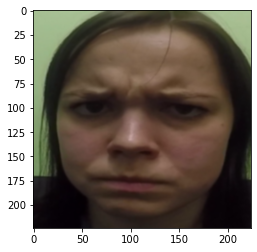

In [64]:

plt.imshow(transforms.ToPILImage()(train_dataset[0][0][7]), interpolation="bicubic")

In [65]:
# np.array(train_dataset[10][0]).shape
for video in train_dataset:
    images,anch_lab, neg_lab= video
    print(images.shape)
    break
    # for frame in images:
    #     print(frame.shape)

torch.Size([8, 3, 224, 224])


In [66]:
def get_embeddings(model,dataset):
  model.eval()
  embeddings = []
  # targets = []
  with torch.no_grad():
    for video in dataset:
      images,anch_lab, neg_lab= video
      # print(np.array(images).shape)
      images = images.to(device)
      # embeddings.append([model(images),anch_lab])

      # break
      # for frame in images:
      #   targets.append(anch_lab)
      #   print(frame.shape)
      #   frame = frame.to(device)
        
      #   emb = model(frame.unsqueeze(0))
      #   print(np.array((frame)).shape)
      #   break
      #   embeddings.append((emb.cpu().numpy(),anch_lab))
      # targets = np.full((len(images)),anch_lab)
      embeddings.append([model(images),anch_lab])
  return embeddings

In [67]:
model.load_state_dict(torch.load("best_model.pt"))
embeddings = get_embeddings(model,train_dataset)
val_embeddings = get_embeddings(model,test_dataset)

In [68]:
trainloader = DataLoader(embeddings, batch_size=1, shuffle=False, num_workers=1)
valloader = DataLoader(val_embeddings, batch_size=1, shuffle=False, num_workers=1)

In [69]:

class LSTM_model(nn.Module):
    def __init__(self,input_features=4096,hidden_size=512 ,num_classes=12):
        super(LSTM_model, self).__init__()
        self.lstm = nn.LSTM(input_features, hidden_size,num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hidden=None
        lstm_out, hidden = self.lstm(x, hidden)
        out = self.fc(lstm_out[:, -1, :])
        
        # out = self.fc(lstm_out[:, -1, :])
        return out

In [70]:
# seq_len = 3
# inp = tor
# ch.randn(1, 8, 4096)
# out, hidden = lstm_layer(inp, hidden)
# print(out.shape)

In [72]:
model2 = LSTM_model(4096,512,6)
model2.to(device)

LSTM_model(
  (lstm): LSTM(4096, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)

In [73]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-6, weight_decay=0.00001)

In [74]:
start_epoch = 0
epochs=30

In [78]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class Logger(object):

    def __init__(self, path, header):
        self.log_file = open(path, 'w')
        self.logger = csv.writer(self.log_file, delimiter='\t')

        self.logger.writerow(header)
        self.header = header

    def __del(self):
        self.log_file.close()

    def log(self, values):
        write_values = []
        for col in self.header:
            assert col in values
            write_values.append(values[col])

        self.logger.writerow(write_values)
        self.log_file.flush()


def load_value_file(file_path):
    with open(file_path, 'r') as input_file:
        value = float(input_file.read().rstrip('\n\r'))

    return value


def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()

    return n_correct_elems / batch_size

In [79]:
for batch_idx, (data, targets) in enumerate(trainloader):
    data, targets = data.to(device), targets.to(device)
    print(targets)
    break

tensor([0], device='cuda:0', dtype=torch.int32)


In [80]:
def train_epoch(model, data_loader, criterion, optimizer, epoch, log_interval, device):
    model.train()
 
    train_loss = 0.0
    losses = AverageMeter()
    accuracies = AverageMeter()
    for batch_idx, (data, targets) in enumerate(data_loader):
        targets = targets.type(torch.LongTensor)
        data, targets = data.to(device), targets.to(device)
        
        outputs = model(data)
        
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)

        train_loss += loss.item()
        losses.update(loss.item(), data.size(0))
        accuracies.update(acc, data.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % log_interval == 0:
            avg_loss = train_loss / log_interval
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(data_loader.dataset), 100. * (batch_idx + 1) / len(data_loader), avg_loss))
            train_loss = 0.0

    print('Train set ({:d} samples): Average loss: {:.4f}\tAcc: {:.4f}%'.format(
        len(data_loader.dataset), losses.avg, accuracies.avg * 100))

    return losses.avg, accuracies.avg  

In [81]:
def val_epoch(model, data_loader, criterion, device):
    model.eval()

    losses = AverageMeter()
    accuracies = AverageMeter()
    with torch.no_grad():
        for (data, targets) in data_loader:
            targets = targets.type(torch.LongTensor)
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)  

            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)

            losses.update(loss.item(), data.size(0))
            accuracies.update(acc, data.size(0))

    # show info
    print('Validation set ({:d} samples): Average loss: {:.4f}\tAcc: {:.4f}%'.format(len(data_loader.dataset), losses.avg, accuracies.avg * 100))
    return losses.avg, accuracies.avg

In [82]:
# tensorboard
import tensorboardX
summary_writer = tensorboardX.SummaryWriter(log_dir='tf_logs')

In [83]:
for epoch in range(start_epoch, epochs):
		train_loss, train_acc = train_epoch(model2, trainloader, criterion, optimizer, epoch, log_interval=240, device=device)
		val_loss, val_acc = val_epoch(model2, valloader, criterion, device)
		if (epoch) % 5 == 0:
			# scheduler.step(val_loss)
			# write summary
			summary_writer.add_scalar(
				'losses/train_loss', train_loss, global_step=epoch)
			summary_writer.add_scalar(
				'losses/val_loss', val_loss, global_step=epoch)
			summary_writer.add_scalar(
				'acc/train_acc', train_acc * 100, global_step=epoch)
			summary_writer.add_scalar(
				'acc/val_acc', val_acc * 100, global_step=epoch)

			state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
			# torch.save(state, os.path.join('snapshots', f'{"model-lst"}-Epoch-{epoch}-Loss-{val_loss}.pth'))
			print("Epoch {} model saved!\n".format(epoch))

Train Epoch: 0 [240/480 (50%)]	Loss: 1.791761
Train Epoch: 0 [480/480 (100%)]	Loss: 1.791761
Train set (480 samples): Average loss: 1.7918	Acc: 16.6667%
Validation set (118 samples): Average loss: 1.7918	Acc: 16.9492%
Epoch 0 model saved!

Train Epoch: 1 [240/480 (50%)]	Loss: 1.791761
Train Epoch: 1 [480/480 (100%)]	Loss: 1.791761
Train set (480 samples): Average loss: 1.7918	Acc: 16.6667%
Validation set (118 samples): Average loss: 1.7918	Acc: 16.9492%
Train Epoch: 2 [240/480 (50%)]	Loss: 1.791761
Train Epoch: 2 [480/480 (100%)]	Loss: 1.791761
Train set (480 samples): Average loss: 1.7918	Acc: 16.6667%
Validation set (118 samples): Average loss: 1.7918	Acc: 16.9492%
Train Epoch: 3 [240/480 (50%)]	Loss: 1.791761
Train Epoch: 3 [480/480 (100%)]	Loss: 1.791761
Train set (480 samples): Average loss: 1.7918	Acc: 16.6667%
Validation set (118 samples): Average loss: 1.7918	Acc: 16.9492%
Train Epoch: 4 [240/480 (50%)]	Loss: 1.791761
Train Epoch: 4 [480/480 (100%)]	Loss: 1.791761
Train set (48

ARTEM

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self,model, input_emb_size=4096 ,num_classes=12):
        super(LSTM_model, self).__init__()
        self.snn= model
        self.lstm = nn.LSTM(input_emb_size, emb_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        hidden=None
        for i in range(x.shape[1]):
            with torch.no_grad():
                emb = self.snn(x[:,i,:])
                emb = emb.unsqueeze(1)
            lstm_out, hidden = self.lstm(emb, hidden)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [ ]:
for epoch in range(100):
    print("Start epoch #%d" % (epoch))
    running_loss = 0.0
    print("-- Training --")
    for i, data in enumerate(trainloader, 0):
        inputs, label = data
        if torch.cuda.is_available():
            inputs = inputs.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
        
        outputs = model2(inputs)

        loss = criterion(outputs, label)
        loss.backward()
        k = torch.argmax(outputs, dim=1) 

        optimizer.step()
        
        running_loss += loss.item()
    running_loss = running_loss / len(trainloader)
    if abs(running_loss - prev_epoch_loss) < 0.001:
        print("Early stopping! Epoch: {:d}, Loss: {:.3f}".format(epoch, running_loss))
        break
    else:
        prev_epoch_loss = running_loss

In [51]:
np.array(train_video_emb[479]).reshape(8,-1).shape

(8, 4096)

In [90]:
class LSTM_model(nn.Module):
    def __init__(self,model, input_emb_size=4096 ,num_classes=12):
        super(LSTM_model, self).__init__()
        self.snn= model
        self.lstm = nn.LSTM(input_emb_size, emb_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        hidden=None
        for i in range(x.shape[1]):
            with torch.no_grad():
                emb = self.snn(x[:,i,:])
                emb = emb.unsqueeze(1)
            lstm_out, hidden = self.lstm(emb, hidden)
        out = self.fc(lstm_out[:, -1, :])
        return out


In [91]:
model2 = LSTM_model()
model2.to(device)

TypeError: __init__() missing 1 required positional argument: 'model'

In [ ]:
def train_epoch(model, model2, data_loader, criterion, optimizer, epoch, log_interval, device):
    model2.train()
 
    train_loss = 0.0
    losses = AverageMeter()
    accuracies = AverageMeter()
    for batch_idx, (data, targets) in enumerate(data_loader):
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)

        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)

        train_loss += loss.item()
        losses.update(loss.item(), data.size(0))
        accuracies.update(acc, data.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % log_interval == 0:
            avg_loss = train_loss / log_interval
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(data_loader.dataset), 100. * (batch_idx + 1) / len(data_loader), avg_loss))
            train_loss = 0.0

    print('Train set ({:d} samples): Average loss: {:.4f}\tAcc: {:.4f}%'.format(
        len(data_loader.dataset), losses.avg, accuracies.avg * 100))

    return losses.avg, accuracies.avg  

In [ ]:
anchor_images = []
for A,P,N in train_dataset:
    anchor_images.append(A)

In [ ]:
import pandas as pd
def get_encoding_csv(model, anc_imgs, anc_img_names):
  anc_img_names_arr = np.array(anc_imgs)
  encodings = []
  model.eval()
  with torch.no_grad():
    for A in tqdm(anc_img_names_arr):
      # A = io.imread(DATA_DIR + i)
      # A = torch.from_numpy(A).permute(2,0,1) / 255.0
      A = A.to(device)
      A_enc = model(A.unsqueeze(0)) #(c,h,w)-> pytorch wants (bs,c,h,w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    # print(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis =1)
  return df_enc



In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
names = pd.DataFrame(train_dataset.files_path, columns = ['Anchor'])
df_enc = get_encoding_csv(model, anchor_images, names)

In [ ]:
# df_enc.to_csv("database.csv",index=False)
df_enc.head()

In [ ]:
def euclidean_distance(img_enc,anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist
from scipy import spatial

def cosine_distance(img_enc,enc_arr):
  # dist = np.dot(img_enc, enc_arr.T) / (np.linalg.norm(img_enc) * np.linalg.norm(enc_arr))
  # dist = cosine_similarity(img_enc,enc_arr)
  dist = 1-spatial.distance.cosine(img_enc,enc_arr)

  return dist

In [ ]:
idx = 56
img = anchor_images[idx]

plt.imshow(img.numpy().transpose((1,2,0)), cmap = 'gray')
# img = torch.from_numpy(img).permute(2,0,1)/255.0
model.eval()
with torch.no_grad():
  img = img.to(device)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()



In [ ]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc["Anchor"]
anc_name = anc_img_names[idx]

In [ ]:
anc_name

In [ ]:
# IDX=59
# closest_idx[IDX]
# anc_name = anc_img_names[idx]

In [ ]:
# IDX=2
# closest_idx[IDX]
# anc_name = anc_img_names[idx]
# img = anchor_images[closest_idx[IDX]]

# plt.imshow(img.numpy().transpose((1,2,0)), cmap = 'gray')
# anc_img_names[closest_idx[IDX]]

In [ ]:
distance = []
method = "euclidean"
for i in range(anc_enc_arr.shape[0]):
  if method == "euclidean":
    dist=euclidean_distance(img_enc, anc_enc_arr[i:i+1,:])
  elif method == "cosine":
    dist = cosine_distance(img_enc, anc_enc_arr[i:i+1,:])
  
  distance = np.append(distance,dist)

In [ ]:
closest_idx = np.argsort(distance)

In [ ]:
# for name in anc_img_names:
#     print(name.split("\\")[-1])

In [ ]:
import networkx as nx 
from skimage import io
import re
import matplotlib.pyplot as plt

def plot_closest_imgs(anchor_images, anc_img_names, closest_idxs, distance, no_of_closest = 10):

    G=nx.Graph()

    # S_name = [img_path.split('\\')[-1]]


    # for s in range(no_of_closest):
    #     S_name.append(anc_img_names.iloc[closest_idxs[s]].split('\\')[-1])
    
    subject = re.split('([0-9]+)',anc_img_names.iloc[closest_idx[0]])[3]
    print(subject)
    #anchor case
    image = anchor_images[closest_idxs[0]].permute(1,2,0)
    G.add_node(0,image = image)  
    # for i in range(no_of_closest + 1):
    #     image = anchor_images[closest_idxs[i]].permute(1,2,0)
    #     G.add_node(i,image = image)
    
    #close images
    for j in range(1,no_of_closest + 1):
        
        image = anchor_images[closest_idxs[j]].permute(1,2,0)
        G.add_node(j,image = image)
        G.add_edge(0,j,weight=distance[closest_idxs[j-1]])
        

    pos=nx.kamada_kawai_layout(G)

    fig=plt.figure(figsize=(20,20))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax)

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)

    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    piesize=0.09 # this is the image size
    p2=piesize/2.0
    # print(piesize,p2)
    for n in G:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        # print(G.nodes[n]['image'])
        a.imshow(G.nodes[n]['image'])
        a.set_title(anc_img_names.iloc[closest_idxs[n]].split('\\')[-1])
        a.axis('off')
    ax.axis('off')
    plt.show()

In [ ]:
anc_img_names[closest_idx[0]]

In [ ]:
# from utils import plot_closest_imgs
plot_closest_imgs(anchor_images, anc_img_names, closest_idx[:], distance, no_of_closest = 12);

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(dista, distb):
    margin = 0
    pred = (dista - distb - margin).cpu().data
    return (pred > 0).sum()*1.0/dista.size()[0]

In [ ]:
from visdom import Visdom
global plotter # global variable to store visdom line plotter

In [ ]:
def train(train_loader, tnet, criterion, optimizer, epoch):
    losses = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()

    # switch to train mode
    tnet.train()
    for batch_idx, (data1, data2, data3) in enumerate(train_loader):
       if device=="cuda":
        data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

        # compute output
        print(data1.shape)
        dista, distb, embedded_x, embedded_y, embedded_z = tnet(data1, data2, data3)
        # 1 means, dista should be larger than distb
        target = torch.FloatTensor(dista.size()).fill_(1)
        if device=="cuda":
            target = target.cuda()
        target = Variable(target)
        
        loss_triplet = criterion(dista, distb, target)
        loss_embedd = embedded_x.norm(2) + embedded_y.norm(2) + embedded_z.norm(2)
        loss = loss_triplet + 0.001 * loss_embedd

        # measure accuracy and record loss
        acc = accuracy(dista, distb)
        losses.update(loss_triplet.data[0], data1.size(0))
        accs.update(acc, data1.size(0))
        emb_norms.update(loss_embedd.data[0]/3, data1.size(0))

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'
                  'Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * len(data1), len(train_loader.dataset),
                losses.val, losses.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))
    # log avg values to somewhere
    plotter.plot('acc', 'train', epoch, accs.avg)
    plotter.plot('loss', 'train', epoch, losses.avg)
    plotter.plot('emb_norms', 'train', epoch, emb_norms.avg)

def test(test_loader, tnet, criterion, epoch):
    losses = AverageMeter()
    accs = AverageMeter()

    # switch to evaluation mode
    tnet.eval()
    for batch_idx, (data1, data2, data3) in enumerate(test_loader):
        if device=="cuda":
            data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

        # compute output
        dista, distb, _, _, _ = tnet(data1, data2, data3)
        target = torch.FloatTensor(dista.size()).fill_(1)
        if device=="cuda":
            target = target.cuda()
        target = Variable(target)
        test_loss =  criterion(dista, distb, target).data[0]

        # measure accuracy and record loss
        acc = accuracy(dista, distb)
        accs.update(acc, data1.size(0))
        losses.update(test_loss, data1.size(0))      

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
        losses.avg, 100. * accs.avg))
    plotter.plot('acc', 'test', epoch, accs.avg)
    plotter.plot('loss', 'test', epoch, losses.avg)
    return accs.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/"%("saves")
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/%s/'%("saves") + 'model_best.pth.tar')

In [ ]:
    n_epochs = 20
    for epoch in range(1, n_epochs + 1):
        # train for one epoch
        train(triplet_train_loader, tnet, criterion, optimizer, epoch)
        # evaluate on validation set
        acc = test(triplet_test_loader, tnet, criterion, epoch)

        # remember best acc and save checkpoint
        is_best = acc > best_acc
        best_acc = max(acc, best_acc)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': tnet.state_dict(),
            'best_prec1': best_acc,
        }, is_best)

In [ ]:
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss
from torch.optim import lr_scheduler
import torch.optim as optim
from trainer import fit


margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if device:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, device, log_interval)

In [ ]:
triplet = []
for video in dataset:
    for i,image in enumerate(video):
        triplet.append((image[0],image[1],image[2],image[3]))
        if i==2:
            break
        # cv2.imshow("image", image[0].cpu().detach().numpy())
    #    triplet.append(image)
    #triplet.append((video[0],video[1],video[2]))
triplet = np.array(triplet)
# triplet.shape

In [ ]:
triplet.shape

In [ ]:
plt.imshow(np.transpose(triplet[11][2].cpu().detach().numpy(), (1, 2, 0)))

In [ ]:
len(triplet)

In [ ]:
embedding_dims = 2
batch_size = 32
epochs = 50

In [ ]:
def imshow(npimg, text=None):
    # npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow((np.transpose(npimg, (1, 2, 0))))
    plt.show() 

In [ ]:
# """uncomment to reorder the dataset"""

# import re
# def sort_human(l,order):
    
#     # for elem in l:
#         # print(re.split('([0-9]+)',elem))
#     if order =="subject_order":
#         return sorted(l, key=lambda i: (re.split('([0-9]+)',i)[3]))
#     else: #emotion order
#         convert = lambda text: float(text) if text.isdigit() else text
#         alphanum = lambda key: [convert(c) for c in re.split('([0-9]+)', key) ]
#         return l.sort(key=alphanum)

In [ ]:
def train_split(dataset,n_subj):
    split_idx = n_subj*12
    train_dataset = []
    val_dataset = []
    for i,video in enumerate(dataset):
        if i<split_idx:
            train_dataset.append(video)
        else:
            val_dataset.append(video)
    return train_dataset,val_dataset

In [ ]:
dataset[0][0].shape

In [ ]:
torch.max(images)

In [ ]:
dataset.get_shape(idx=597)
print("\n",dataset.files_path[:25])

In [ ]:
train_dataset , val_dataset = train_split(dataset,n_subj = 40)

In [ ]:
print('Training samples:', len(train_dataset))
print('Validation samples:', len(val_dataset))


In [ ]:
from torchsummary import summary

In [ ]:
model = init_model("ResNet50",num_classes=len(set(dataset.get_file_labels())))

In [ ]:
model

In [ ]:
writer = SummaryWriter(log_dir="weights/")
optim = torch.optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
len(val_dataset)

In [ ]:
emo_list = ["Fake-Angry","Fake-Contempt","Fake-Disgust", "Fake-Happy", "Fake-Sad", "Fake-Surprise", "Real-Angry", "Real-Contempt", "Real-Disgust", "Real-Happy", "Real-Sad", "Real-Surprise"]

In [ ]:
train_new=[]
val_new=[]

for video, label,subj in train_dataset:
    for vid in video:
        train_new.append([vid,label])

for video, label,subj in val_dataset:
    for vid in video:
        val_new.append([vid,label])

In [ ]:
import time

In [ ]:
def train(model, criterion, train_dataset, val_dataset, batch_size, optimizer, step, max_epochs, model_name, no_val=False):
    epoch_time= None
    # max_epochs = tqdm(range(max_epochs+1), desc="Epochs")
    prev_epoch_loss = 0.0
    # emo_list = train_dataset.dataset.get_labels_string()

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    if not no_val:
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    else:
        val_loss = 0
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=0.1, verbose=True)

    last_epoch = False
    stop_count = 0


    best_train_loss = [999, -1]
    best_val_loss = [999, -1]

    for epoch in range(max_epochs):
        start_time = time.time()
        print("Start epoch #%d," % (epoch))
        remaining_epochs=max_epochs-epoch
        if epoch_time is not None:
            print("ETA: %s" % (time.strftime("%H:%M:%S", time.gmtime(epoch_time * remaining_epochs))))
        running_loss = 0.0
        print("/n/n/n/n/n/n/n/ -- Training --")
        model.train()
        # train_dataset.dataset.set_split("train")
        for i, (videos,labels) in enumerate(trainloader, 0):
                                                # print("my label initial ",label, "/n/n",inputs.shape)
            inputs = videos
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                                                # inputs = inputs.to(device)
                                                # print("my label is",label, "/n/n",inputs.size())
                                                # label= label.to(device)
                label= labels.to(device)
                # label = label.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            if outputs.shape[-1] == 1:
                label = label.unsqueeze(1)

            loss = criterion(outputs, label).to(device)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if i % 80 == 0:
                print("Progress: {:d}/{:d}. Loss:{:.3f}".format(i, len(trainloader), running_loss/(i+1)))


        running_loss = running_loss / len(trainloader)

        if running_loss < best_train_loss[0]:
            best_train_loss[0] = running_loss
            best_train_loss[1] = epoch
            if no_val:
                torch.save(model.state_dict(), "../weights/"+model_name+"_final.pt")

        if abs(running_loss - prev_epoch_loss) < 0.001:
            print("Early stopping! Epoch: {:d}, Loss: {:.3f}".format(epoch, running_loss))
            stop_count += 1
            if stop_count == 3:
                last_epoch = True
            prev_epoch_loss = running_loss
        else:
            prev_epoch_loss = running_loss
            stop_count = 0

        if not no_val:
            print("Validation")
            model.eval()
            # val_dataset.dataset.set_split("val")

            with torch.no_grad():
                test_loss = 0.0
                y_pred= []
                y_true = []
                for i, (videos,val_labels) in enumerate(valloader):
                                                # for inputs,label in zip(videos,val_labels):
                        # print("my label no_grad ",label, "/n/n",inputs.shape)
                    inputs = videos
                    if torch.cuda.is_available():
                        inputs = inputs.to(device)
                        label = val_labels.to(device)
                                                # inputs = inputs.to(device)
                                                # label = label.to(device)

                    outputs = model(inputs)
                    
                    if outputs.shape[-1] > 1:
                        o_labels = torch.argmax(outputs, dim=1)
                    else:
                        label = label.unsqueeze(1)
                        o_labels = torch.round(outputs)

                    y_pred.append(o_labels.cpu())
                    y_true.append(label.cpu())

                    loss = criterion(outputs, label)

                    test_loss += loss.item()
                    if i%10 == 0:
                        print("Progress: {:d}/{:d}".format(i, len(valloader)))
                    

                y_pred = torch.cat(y_pred).numpy()
                y_true = torch.cat(y_true).numpy()
                val_loss = test_loss / len(valloader)
                print("Validation loss: {:f}".format(val_loss))
                print("Confusion matrix")
                # print(confusion_matrix(labels, pred))
                print(confusion_matrix(y_true, y_pred))
                print(classification_report(y_true, y_pred, target_names=emo_list,zero_division=1))
                # print(classification_report(labels, pred, target_names=emo_list,zero_division=1))

                if val_loss < best_val_loss[0]:
                    best_val_loss[0] = val_loss
                    best_val_loss[1] = epoch
                    torch.save(model.state_dict(), "weights/"+model_name+".pt")

        writer.add_scalars("losses", {'train': running_loss, 'val': val_loss}, epoch)
        scheduler.step()
        if last_epoch:
            break
        epoch_time = time.time() - start_time
    return best_train_loss, best_val_loss


In [ ]:
train_loss, val_loss = train(model, criterion, train_new, val_new,
                                batch_size= n_frames, optimizer= optim, step =0.005, max_epochs=100,
                                model_name="ResNet152_pretrained_"+str(n_frames)+"_frames",
                                no_val=False)
                                
# train_loss, val_loss = train(model, criterion, train_dataset, val_dataset,
#                                 1, optim, step =0.005, max_epochs=100,
#                                 model_name="Resnet324",
#                                 no_val=False)

In [ ]:
# import os
# os.system("rundll32.exe powrprof.dll,SetSuspendState 0,1,0")

In [ ]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow((np.transpose(npimg, (1, 2, 0))))
    plt.show() 

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=2)

In [ ]:
example_batch[0][0]

In [ ]:
example_batch = next(iter(trainloader))
print(example_batch[1])

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0][0], example_batch[0][1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
plt.hist(example_batch[0][1].numpy().ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

In [ ]:
print("Best train loss:", train_loss)
print("Best val loss:", val_loss)
writer.add_hparams( {"lr":0.0001, "decay":0.01, "batch":n_frames},
                    {"best_train_loss": train_loss[0], "best_val_loss": val_loss[0]}, run_name=str("version1"))

writer.close()

In [ ]:
def train(model, criterion, train_dataset, val_dataset, batch_size, optimizer, step, max_epochs, model_name, no_val=False):
    epoch_time= None
    # max_epochs = tqdm(range(max_epochs+1), desc="Epochs")
    prev_epoch_loss = 0.0
    # emo_list = train_dataset.dataset.get_labels_string()

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    if not no_val:
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    else:
        val_loss = 0
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=0.1, verbose=True)

    last_epoch = False
    stop_count = 0

    train_accuracy_score=0
    val_accuracy_score=0
    y_pred_train= []
    y_true_train = []
    best_train_loss = [999, -1]
    best_val_loss = [999, -1]

    for epoch in range(max_epochs):
        train_accuracy_score=0
        val_accuracy_score=0
        running_loss = 0.0
        start_time = time.time()
        print("Start epoch #%d," % (epoch))
        remaining_epochs=max_epochs-epoch
        if epoch_time is not None:
            print("ETA: %s" % (time.strftime("%H:%M:%S", time.gmtime(epoch_time * remaining_epochs))))
        
        
        print("/n/n/n/n/n/n/n/ -- Training --")
        model.train()
        # train_dataset.dataset.set_split("train")
        for i, (videos,labels) in enumerate(trainloader, 0):
                                                # print("my label initial ",label, "/n/n",inputs.shape)
            inputs = videos
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                label= labels.to(device)
                # label = label.to(device)


            optimizer.zero_grad()

            outputs = model(inputs)
            if outputs.shape[-1] == 1:
                label = label.unsqueeze(1)
            
            if outputs.shape[-1] > 1:
                o_labels = torch.argmax(outputs, dim=1)
            else:
                label = label.unsqueeze(1)
                o_labels = torch.round(outputs)

            y_pred_train.append(o_labels.cpu())
            y_true_train.append(label.cpu())

            loss = criterion(outputs, label).to(device)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % 80 == 0:
                print("Progress: {:d}/{:d}. Loss:{:.3f}".format(i, len(trainloader), running_loss/(i+1)))


        pred = torch.cat(y_pred_train).numpy()
        true = torch.cat(y_true_train).numpy()
        train_accuracy_score= np.count_nonzero(pred == true)/len(pred)
        print("Accuracy: %.3f" % (train_accuracy_score))
        running_loss = running_loss / len(trainloader)


        if running_loss < best_train_loss[0]:
            best_train_loss[0] = running_loss
            best_train_loss[1] = epoch
            if no_val:
                torch.save(model.state_dict(), "../weights/"+model_name+"_final.pt")

        if abs(running_loss - prev_epoch_loss) < 0.001:
            print("Early stopping! Epoch: {:d}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch, running_loss, train_accuracy_score))
            stop_count += 1
            if stop_count == 3:
                last_epoch = True
            prev_epoch_loss = running_loss
        else:
            prev_epoch_loss = running_loss
            stop_count = 0

        if not no_val:
            print("Validation")
            model.eval()
            # val_dataset.dataset.set_split("val")

            with torch.no_grad():
                test_loss = 0.0
                y_pred= []
                y_true = []
                for i, (videos,val_labels) in enumerate(valloader):
                                                # for inputs,label in zip(videos,val_labels):
                        # print("my label no_grad ",label, "/n/n",inputs.shape)
                    inputs = videos
                    if torch.cuda.is_available():
                        inputs = inputs.to(device)
                        label = val_labels.to(device)
                                                # inputs = inputs.to(device)
                                                # label = label.to(device)

                    outputs = model(inputs)
                    
                    if outputs.shape[-1] > 1:
                        o_labels = torch.argmax(outputs, dim=1)
                    else:
                        label = label.unsqueeze(1)
                        o_labels = torch.round(outputs)

                    y_pred.append(o_labels.cpu())
                    y_true.append(label.cpu())

                    loss = criterion(outputs, label)

                    test_loss += loss.item()
                    if i%100 == 0:
                        print("Progress: {:d}/{:d}".format(i, len(valloader)))
                    

                pred = torch.cat(y_pred).numpy()
                true = torch.cat(y_true).numpy()
                val_loss = test_loss / len(valloader)
                val_accuracy_score = np.count_nonzero(pred == true)/len(pred)
                print("Validation Accuracy: %.3f" % (val_accuracy_score))
                print("Validation loss: {:f}".format(val_loss))
                print("Confusion matrix")
                # print(confusion_matrix(labels, pred))
                print(confusion_matrix(y_true, y_pred))
                print(classification_report(y_true, y_pred, target_names=emo_list,zero_division=1))
                # print(classification_report(labels, pred, target_names=emo_list,zero_division=1))
                if val_loss < best_val_loss[0]:
                    best_val_loss[0] = val_loss
                    best_val_loss[1] = epoch
                    torch.save(model.state_dict(), "weights/"+model_name+".pt")

        writer.add_scalars("losses", {'train': running_loss, 'val': val_loss}, epoch)
        # writer.add_scalar("train_accuracy", {'train': train_accuracy_score, 'val': val_accuracy_score}, epoch)
        scheduler.step()
        if last_epoch:
            break
        epoch_time = time.time() - start_time
    return best_train_loss, best_val_loss
